# Importing Libraries 

In [1]:
!pip install implicit

You should consider upgrading via the 'C:\Users\zhuzh\OneDrive\Desktop\AI Facial recognition\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,manhattan_distances
import seaborn as sns
import implicit 
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
sns.set(style = 'white')

# Data Preprocessing

In [3]:
df_singapore=pd.read_csv('SingaporePreferences.csv')
df_singapore.drop(['UserID','Top 6 most preferred places','sum'], axis=1, inplace=True)

In [4]:
df_singapore = df_singapore.fillna(0)

In [5]:
grp_dict={}
test_data={}
grp = df_singapore.groupby(['Gender','Age Group'])
for name, df in grp:
    df.drop(['Gender','Age Group'], axis=1, inplace=True)
    df=df.reset_index().drop(['index'],axis=1)
    df_mat=np.array(df)
    test_indxs=[]
    ### extract test data ###
    for i in range(len(df)):
        indxs=np.where(np.array(df.iloc[i])==1)[0]
        test_indx=np.random.choice(indxs, size=1)[0]
        df_mat[i][test_indx]=0
        test_indxs.append(test_indx)
    ##########################
    test_data[name]=test_indxs
    grp_dict[name]=df_mat
keys=list(grp_dict.keys())
singapores=np.array(df.columns)

In [6]:
df_anly=df_singapore.groupby(['Gender','Age Group']).sum().reset_index()

In [7]:
df_anly['group id']=[i for i in range(len(df_anly))]

## model1 (features from user-singapore matrix & cosine similarity)

In [8]:
sim_mat_dic_m1={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    singapore_similarity_matrix=cosine_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m1[keys[i]]=singapore_similarity_matrix

## model 2 (features from Svd & cosine similarity)

In [9]:
sim_mat_dic_m2={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    R = np.array(df).T
    mean = np.mean(R, axis = 1)
    data_matrix = R - mean.reshape(-1, 1)
    U, sigma, Vt = svds(data_matrix, k = np.min(data_matrix.shape)-1)
    sigma = np.diag(sigma)
    feature_matrix=np.dot(U, sigma)
    singapore_similarity_matrix=cosine_similarity(feature_matrix,feature_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m2[keys[i]]=singapore_similarity_matrix

## Model3 (features from user-singapore matrix & euclidean distance similarity)

In [10]:
def euclidean_similarity(matrix1,matrix2):
    euclidean_dist=euclidean_distances(matrix1,matrix2)#find distance 
    scaler = MinMaxScaler()#scale it
    # 
    euclidean_dist_scaled = scaler.fit_transform(euclidean_dist)
    euclidean_sim=1-euclidean_dist_scaled #minus 1 to find similarity 
    return(euclidean_sim)

In [11]:
sim_mat_dic_m3={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    singapore_similarity_matrix=euclidean_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on ed similarity
    sim_mat_dic_m3[keys[i]]=singapore_similarity_matrix

## Model4 (features from user-singapore matrix & manhattan distance similarity)

In [12]:
def manhattan_similarity(matrix1,matrix2):
    manhattan_dist=manhattan_distances(matrix1,matrix2)#find distance 
    scaler = MinMaxScaler()#scale it
    # transform data
    manhattan_dist_scaled = scaler.fit_transform(manhattan_dist)
    manhattan_sim=1-manhattan_dist_scaled #minus 1 to find similarity 
    return(manhattan_sim)


In [13]:
sim_mat_dic_m5={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    singapore_similarity_matrix= manhattan_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on md similarity
    sim_mat_dic_m5[keys[i]]=singapore_similarity_matrix

# Evaluating models part

In [14]:
def rmse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.sqrt(np.mean((test-1)**2)) # calculation of  error
    return(err)

In [15]:
def mse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.mean((test-1)**2) # calculation of  error
    return(err)

In [16]:
def mape_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.mean(abs(test-1)) # calculation of  error
    return(err)

In [17]:
cosine_rmse=[]
svd_rmse=[]
euclidean_rmse=[]
mahanttan_rmse=[]


cosine_mse=[]
svd_mse=[]
euclidean_mse=[]
mahanttan_mse=[]


cosine_mape=[]
svd_mape=[]
euclidean_mape=[]
mahanttan_mape=[]


for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    weight=(1/np.sum(data_matrix!=0,axis=0))
    singapore_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]
    singapore_similarity_matrix_m2=sim_mat_dic_m2[keys[i]]
    singapore_similarity_matrix_m3=sim_mat_dic_m3[keys[i]]
    singapore_similarity_matrix_m5=sim_mat_dic_m5[keys[i]]
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,singapore_similarity_matrix_m1).T*(data_matrix==0)*weight
    data_matrix_filed_m2=data_matrix+np.matmul(data_matrix.T,singapore_similarity_matrix_m2).T*(data_matrix==0)*weight
    data_matrix_filed_m3=data_matrix+np.matmul(data_matrix.T,singapore_similarity_matrix_m3).T*(data_matrix==0)*weight
    data_matrix_filed_m5=data_matrix+np.matmul(data_matrix.T,singapore_similarity_matrix_m5).T*(data_matrix==0)*weight

    #rmse 
    cosine_rmse.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_rmse.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]])) 
    euclidean_rmse.append(rmse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_rmse.append(rmse_calc(data_matrix_filed_m5,test_data[keys[i]])) 
  

    #mse
    cosine_mse.append(mse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_mse.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]])) 
    euclidean_mse.append(mse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_mse.append(mse_calc(data_matrix_filed_m5,test_data[keys[i]]))
  

    #mape
    cosine_mape.append(mape_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_mape.append(mape_calc(data_matrix_filed_m2,test_data[keys[i]]))
    euclidean_mape.append(mape_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_mape.append(mape_calc(data_matrix_filed_m5,test_data[keys[i]]))
    ############################################################

In [18]:
rmse_m1=[]
rmse_m2=[]
rmse_m3=[]
rmse_m5=[]
mse_m1=[]
mse_m2=[]
mse_m3=[]
mse_m5=[]

mape_m1=[]
mape_m2=[]
mape_m3=[]
mape_m5=[]
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    weight=(1/np.sum(data_matrix!=0,axis=0))
    food_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]
    food_similarity_matrix_m2=sim_mat_dic_m2[keys[i]]
    food_similarity_matrix_m3=sim_mat_dic_m3[keys[i]]
    food_similarity_matrix_m5=sim_mat_dic_m5[keys[i]]
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m1).T*(data_matrix==0)*weight
    data_matrix_filed_m2=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m2).T*(data_matrix==0)*weight
    data_matrix_filed_m3=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m3).T*(data_matrix==0)*weight
    data_matrix_filed_m5=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m5).T*(data_matrix==0)*weight
    rmse_m1.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    rmse_m2.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]]))
    rmse_m3.append(rmse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    rmse_m5.append(rmse_calc(data_matrix_filed_m5,test_data[keys[i]]))  
    mse_m1.append(mse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    mse_m2.append(mse_calc(data_matrix_filed_m2,test_data[keys[i]]))
    mse_m3.append(mse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mse_m5.append(mse_calc(data_matrix_filed_m5,test_data[keys[i]]))  
    mape_m1.append(mape_calc(data_matrix_filed_m1,test_data[keys[i]]))
    mape_m2.append(mape_calc(data_matrix_filed_m2,test_data[keys[i]]))
    mape_m3.append(mape_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mape_m5.append(mape_calc(data_matrix_filed_m5,test_data[keys[i]]))
    ############################################################

# Plotting Line Graph with markers at each point 

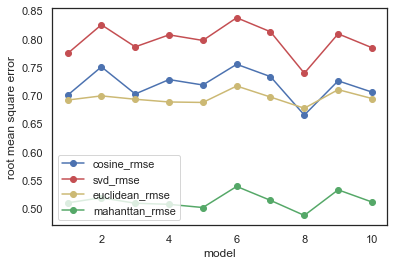

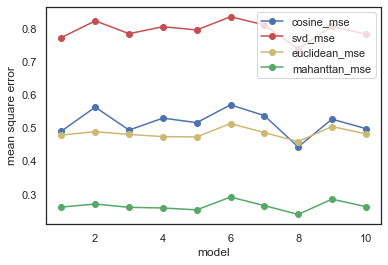

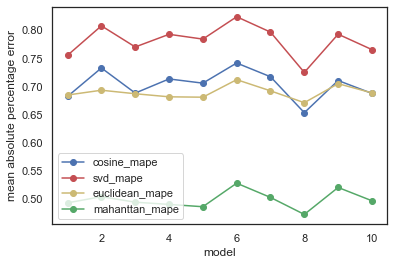

In [19]:
plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_rmse,'b',label='cosine_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_rmse,'r',label='svd_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_rmse,'y',label='euclidean_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_rmse,'g',label='mahanttan_rmse', marker = 'o')

plt.legend()
plt.xlabel('model')
plt.ylabel('root mean square error')
plt.show()

plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_mse,'b',label='cosine_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_mse,'r',label='svd_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_mse,'y',label='euclidean_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_mse,'g',label='mahanttan_mse', marker = 'o')

plt.legend()
plt.xlabel('model')
plt.ylabel('mean square error')
plt.show()


plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_mape,'b',label='cosine_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_mape,'r',label='svd_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_mape,'y',label='euclidean_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_mape,'g',label='mahanttan_mape', marker = 'o')


plt.legend()
plt.xlabel('model')
plt.ylabel('mean absolute percentage error')
plt.show()

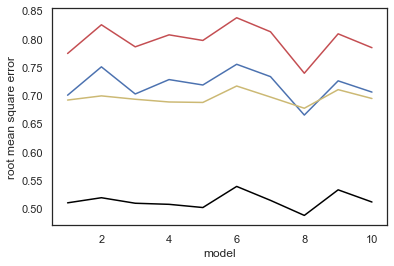

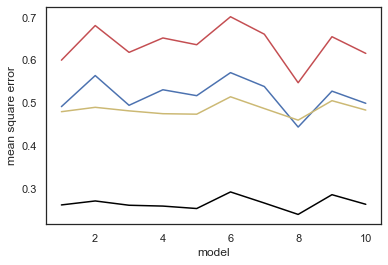

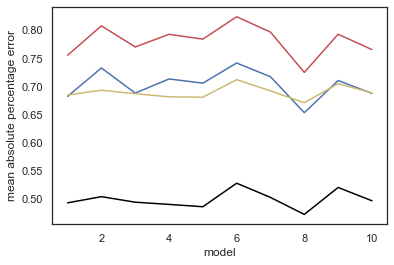

In [20]:
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m1,'b',label='rmse_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m2,'r',label='rmse_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m3,'y',label='rmse_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m5,'black',label='rmse_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('root mean square error')
plt.show()

plt.plot([i+1 for i in range(len(rmse_m1))],mse_m1,'b',label='mse_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m2,'r',label='mse_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m3,'y',label='mse_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m5,'black',label='mse_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('mean square error')
plt.show()


plt.plot([i+1 for i in range(len(rmse_m1))],mape_m1,'b',label='mape_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m2,'r',label='mape_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m3,'y',label='mape_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m5,'black',label='mape_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('mean absolute percentage error')
plt.show()

# **RMSE **

In [21]:
a=cosine_rmse
b=svd_rmse
c=euclidean_rmse
d=mahanttan_rmse

print(a)
print(b)
print(c)
print(d)

[0.7007173899745135, 0.7508092975807656, 0.7029010294200212, 0.7283270393105522, 0.7187761740078201, 0.7553342045952985, 0.7335256185069116, 0.6656872997428656, 0.7260916756035479, 0.7062360532365539]
[0.7743877298843089, 0.8250881361741486, 0.7861339223978309, 0.8072945677667989, 0.7974282402184139, 0.8374948218227369, 0.8127299402010131, 0.7395462471883111, 0.8091025663263945, 0.7846138832190523]
[0.6921831589871218, 0.6995510820304998, 0.6935871442110819, 0.6887792197233013, 0.6879709575661129, 0.7169580790329425, 0.6974919315515086, 0.677735605477266, 0.7105590506090389, 0.6949020635095517]
[0.5107383946679833, 0.5197620050537982, 0.5100129989892733, 0.5080907916211798, 0.5024427140014174, 0.5397027211919256, 0.5150868222577728, 0.4885196187573139, 0.5336932854193119, 0.5121833358002676]


# **MSE Group**

In [22]:
a=cosine_mse
b=svd_mse
c=euclidean_mse
d=mahanttan_mse

print(a)
print(b)
print(c)
print(d)

[0.4910048606126945, 0.5637146013337228, 0.49406985715972557, 0.5304602761908747, 0.51663918832132, 0.5705297606316123, 0.5380598330059472, 0.44313958103894774, 0.5272091213807678, 0.49876936289114465]
[0.7743877298843089, 0.8250881361741486, 0.7861339223978309, 0.8072945677667989, 0.7974282402184139, 0.8374948218227369, 0.8127299402010131, 0.7395462471883111, 0.8091025663263945, 0.7846138832190523]
[0.47911752558539106, 0.48937171637004295, 0.4810631266148842, 0.47441681352263976, 0.4733040384544344, 0.514028887090607, 0.4864949945794544, 0.45932555093163624, 0.5048941644024187, 0.48288887786983314]
[0.26085370778802874, 0.2701525418975446, 0.26011325913803246, 0.2581562525302371, 0.25244868085311006, 0.29127902726196947, 0.2653144344636104, 0.23865141791079136, 0.2848285229016591, 0.2623317694714898]


# **MAPE group**

In [23]:
a5=cosine_mape
b5=svd_mape
c5=euclidean_mape
d5=mahanttan_mape

print(a5)
print(b5)
print(c5)
print(d5)

[0.6821981881116648, 0.7327217900822719, 0.6880710387225141, 0.7131867652638416, 0.705707223255347, 0.7415358241945095, 0.7171011868712328, 0.6531600382887407, 0.7104078991330638, 0.6874749904139338]
[0.7553268937336374, 0.8076798259937925, 0.7700807465978158, 0.7925870695678128, 0.7840657480666373, 0.8238318061517137, 0.7964894226978972, 0.7248173260381129, 0.79278156560861, 0.7653798997330699]
[0.6846116380444368, 0.6931345111183784, 0.6868766815739555, 0.6814099052279505, 0.6807308144443202, 0.7119170782437381, 0.6920382280630774, 0.6709805131939773, 0.7047841702728372, 0.6883998881670453]
[0.492843212472959, 0.5038162708750944, 0.4939865423209953, 0.490050670019851, 0.4859139851595688, 0.5277663931510086, 0.5024415582083649, 0.4722408751117864, 0.5201916127260308, 0.4965136483776339]
